### Imports

In [1]:
import pandas as pd
import surprise
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from surprise import accuracy
import pickle
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from matplotlib import pyplot as plt
from surprise import Dataset

In [2]:
links = pd.read_csv('/Users/gabrielwarner/Downloads/ml-latest-small/links.csv')

In [3]:
movies = pd.read_csv('/Users/gabrielwarner/Downloads/ml-latest-small/movies.csv')

In [4]:
ratings = pd.read_csv('/Users/gabrielwarner/Downloads/ml-latest-small/ratings.csv')

In [5]:
tags = pd.read_csv('/Users/gabrielwarner/Downloads/ml-latest-small/tags.csv')

In [6]:
ratings = ratings.drop('timestamp', axis=1)

### Merge Data Frames

In [7]:
new = pd.merge(links, movies, on='movieId')

In [8]:
new_2 = pd.merge(new, ratings, on='movieId')

In [9]:
new_3 = pd.merge(new_2, tags, on='movieId')

### Preprocessing

In [10]:
# replace | with , in the genres column
new_3['genres'] = new_3['genres'].str.replace('|',' , ')

In [11]:
# convert df to a csv file
new_3.to_csv('/Users/gabrielwarner/Data-Science/Projects/phase_4/movies_2.csv')

### EDA

<AxesSubplot:>

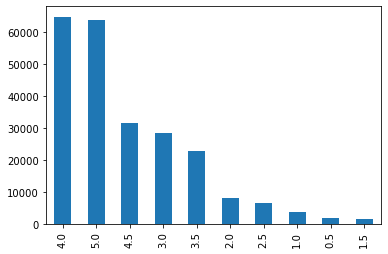

In [12]:
new_3.rating.value_counts().plot(kind='bar')

<AxesSubplot:>

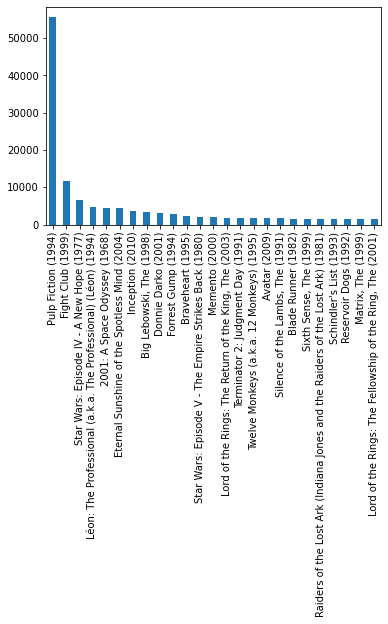

In [13]:
new_3.title.value_counts().head(25).plot(kind='bar')

In [14]:
cmcount = new_3['title'].value_counts(normalize=True).to_dict() 
#count of times this show up on the overall data

In [15]:
cm = new_3.groupby(['title']).mean().sort_values(by='rating', ascending=False)['rating'].to_dict()

Text(0, 0.5, 'Weighted Rating')

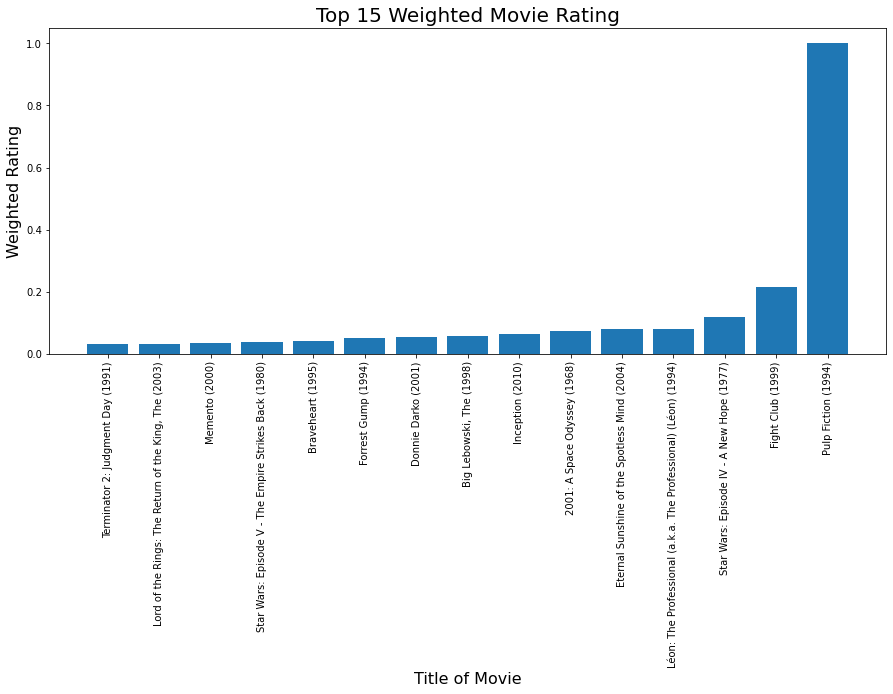

In [16]:
movie = new_3['title'].unique()
weighted_rating = []
for title in movie:
    count = cmcount[title]
    rating = cm[title]
    weighted_rating.append(count * rating)
sorted_vals = sorted(list(zip(weighted_rating, movie)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]
plt.figure(figsize=(15,6))
plt.bar(x[-15:], y[-15:])
plt.xticks(rotation=90);
plt.title('Top 15 Weighted Movie Rating', fontsize=20)
plt.xlabel('Title of Movie', fontsize=16)
plt.ylabel('Weighted Rating', fontsize=16)

<AxesSubplot:>

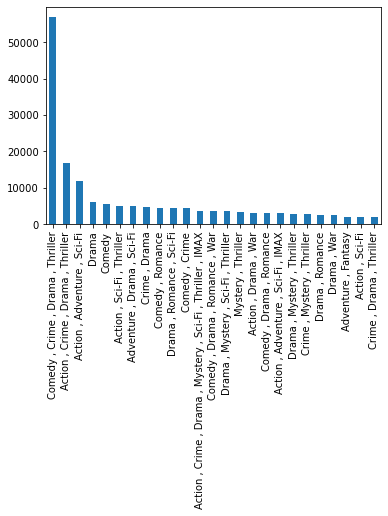

In [17]:
new_3.genres.value_counts().head(25).plot(kind='bar')

In [18]:
cm_2 = new_3.groupby(['genres']).mean().sort_values(by='rating', ascending=False)['rating'].to_dict()

In [19]:
cmcount_2 = new_3['genres'].value_counts(normalize=True).to_dict()

Text(0, 0.5, 'Weighted Rating')

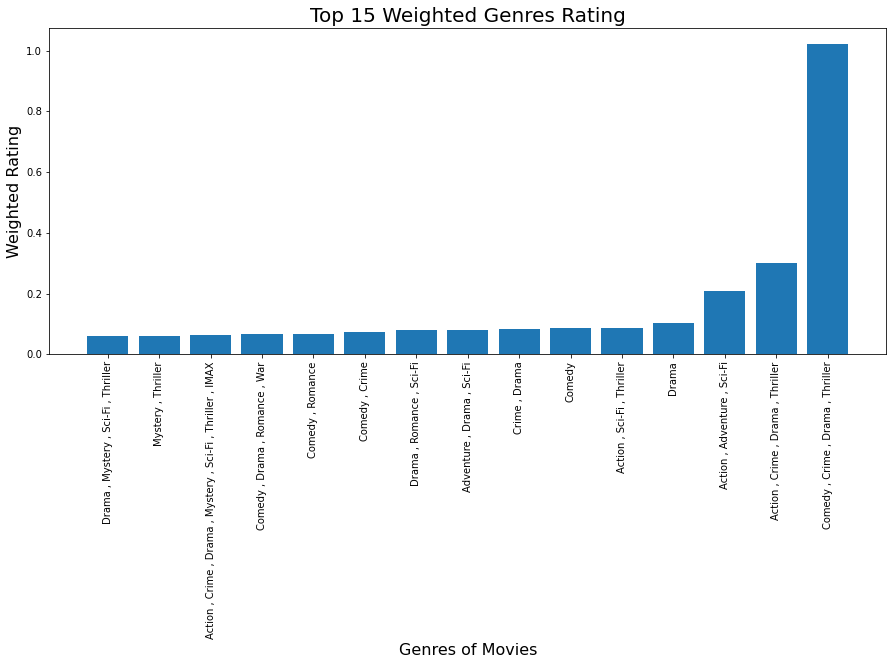

In [20]:
movie = new_3['genres'].unique()
weighted_rating = []
for genres in movie:
    count = cmcount_2[genres]
    rating = cm_2[genres]
    weighted_rating.append(count * rating)
sorted_vals = sorted(list(zip(weighted_rating, movie)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]
plt.figure(figsize=(15,6))
plt.bar(x[-15:], y[-15:])
plt.xticks(rotation=90);
plt.title('Top 15 Weighted Genres Rating', fontsize=20)
plt.xlabel('Genres of Movies', fontsize=16)
plt.ylabel('Weighted Rating', fontsize=16)

<AxesSubplot:>

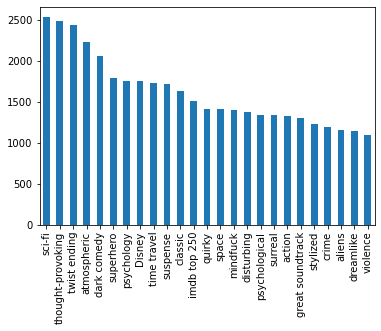

In [21]:
new_3.tag.value_counts().head(25).plot(kind='bar')

### Surprise Preprocessing

In [22]:
reader = surprise.Reader(rating_scale = (4., 5.))

In [23]:
data = surprise.Dataset.load_from_df(ratings, reader)

In [24]:
trainset, testset = train_test_split(data, test_size=0.2)

### KNNS Basic model

In [25]:
# Initiate knn model and fir to trainset
basic = knns.KNNBasic()
basic.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
# make predictions wih the model
predictions = basic.test(testset)

In [27]:
# Get the RMSE score
print(accuracy.rmse(predictions))

RMSE: 1.1578
1.1578344957764026


### KNN means model

In [28]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1573
1.1572824710399945


### Suprise with grid search SVD

In [29]:
param_grid = {'n_factors':[20, 50, 75, 100],'n_epochs': [5, 6, 7, 8, 9, 10, 11], 'lr_all': [0.002, .003, .004, 0.005],
               'reg_all': [.02, 0.4, .5, 0.6]}
gs = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2240 out of 2240 | elapsed: 13.6min finished


In [30]:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.1533
1.1533473136690997


### Pickle

In [31]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(gs)
 
# Load the pickled model
gs_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
#gs_from_pickle.predict(trainset)

### Final Recommendation System

In [34]:
# merge the ratings and movies df on the movieId column
merged_data = pd.merge(ratings , movies, on='movieId')

In [35]:
# convert to a surprise df
Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [36]:
rating_data = pd.DataFrame(merged_data.groupby('title')['rating','movieId','userId'].mean())

<ipython-input-36-1d1185663607>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rating_data = pd.DataFrame(merged_data.groupby('title')['rating','movieId','userId'].mean())


In [37]:
rating_data['# of ratings'] = merged_data.groupby('title')['rating'].count()

In [38]:
ratings_matrix = merged_data.pivot_table(index='userId',columns='title',values='rating')
ratings_matrix.to_csv('./ratings_matrix.csv', index = False)

In [39]:
def movie_recommendations(movie_name):
    user_ratings = ratings_matrix[movie_name]
    correlation_with_movie = pd.DataFrame(ratings_matrix.corrwith(user_ratings))
    correlation_with_movie = correlation_with_movie.join(rating_data['# of ratings'])
    correlation_with_movie.columns = [f'Corr. With {movie_name}', '# of Ratings']
    correlation_with_movie.index.names = ['Movie Title']
    #return correlation_with_movie[correlation_with_movie['# of Ratings'] > 50].sort_values(f'Corr. With {movie_name}', ascending = False).iloc[1:,:].head(10)
    return correlation_with_movie[correlation_with_movie['# of Ratings'] > 50].sort_values(f'Corr. With {movie_name}', ascending = False).iloc[1:,:0].head(5)

In [40]:
movie_recommendations('Toy Story (1995)')

/Users/gabrielwarner/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/gabrielwarner/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


""
Movie Title
Toy Story 2 (1999)
Arachnophobia (1990)
"Incredibles, The (2004)"
Finding Nemo (2003)
Aladdin (1992)
